# Step 04
# Evaluation of performance

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation
import utils.metrics
from config import config_vars

# Configuration

In [5]:

# Partition of the data to make predictions (test or validation)
config_vars['path_files_training'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/1-2_training.txt'
config_vars['path_files_validation'] ='/home/maloua/Malou_Master/5_Models/2_Final_Models/29_model29/metadata/validation.txt'
config_vars['path_files_test'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/TEST.txt'

partition = "validation"

experiment_name = 'Model_29'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars
config_vars["normalized_images_dir"] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/norm_images/'
config_vars["model_file"] = '/home/maloua/Malou_Master/5_Models/1_testing_models/1_carpenter_repo/data/experiments/01/model.hdf5'
config_vars["raw_annotations_dir"] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/1_raw_annotations/'

In [6]:

modellog = pd.read_csv(config_vars["csv_log_file"])
#print(modellog.dtypes)

pd.DataFrame.plot(modellog)
ax = plt.gca()
modellog.plot(x = 'epoch', y = 'val_loss', ax = ax)
modellog.plot(x = 'epoch', y = 'loss', ax = ax)

FileNotFoundError: [Errno 2] File /home/maloua/Malou_Master/5_Models/2_Final_Models/28_model28/data/experiments/Model_29/log.csv does not exist: '/home/maloua/Malou_Master/5_Models/2_Final_Models/28_model28/data/experiments/Model_29/log.csv'

In [4]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

# Auxiliary visualization function

In [7]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

# Run the evaluation
Predictions are stored in Step 03 and loaded here for evaluation

/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/sw/easybuild/software/Anaconda3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


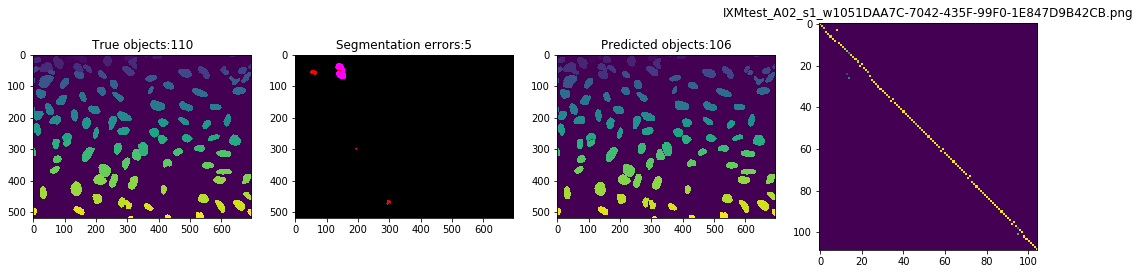

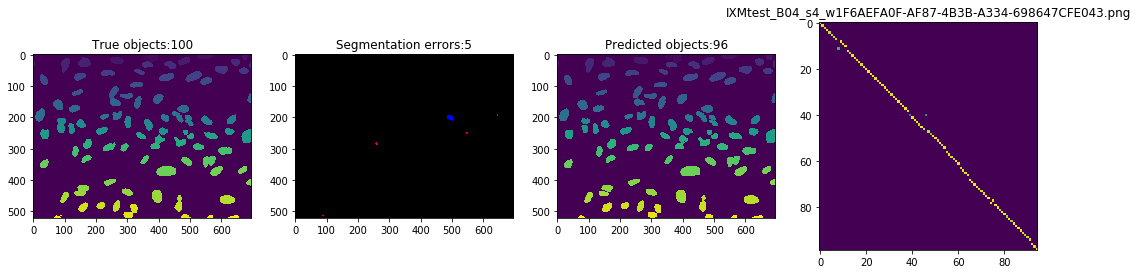

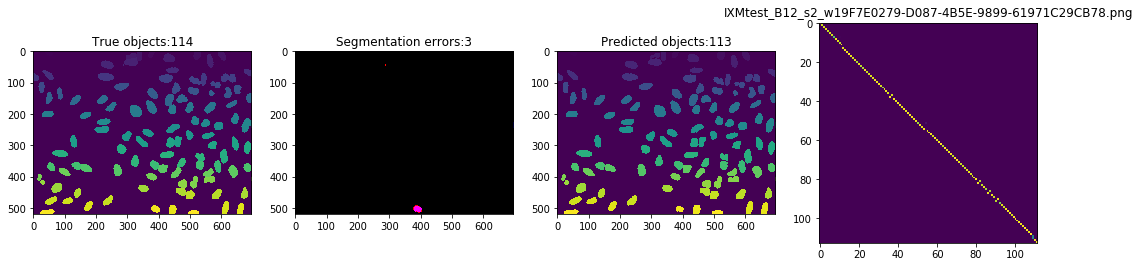

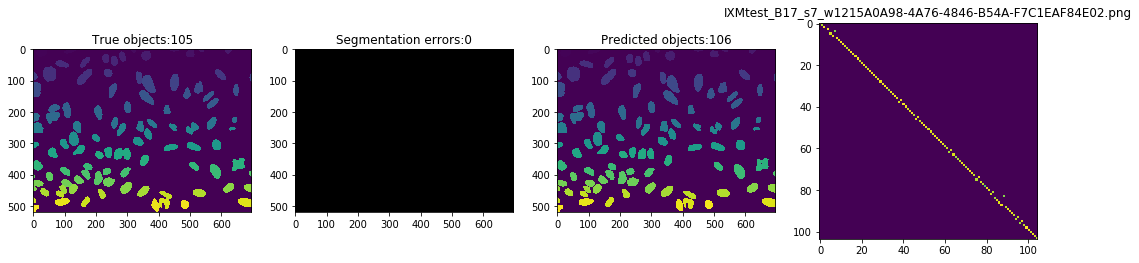

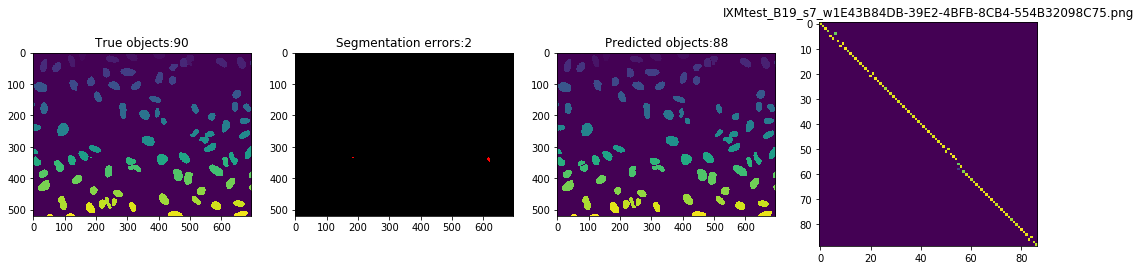

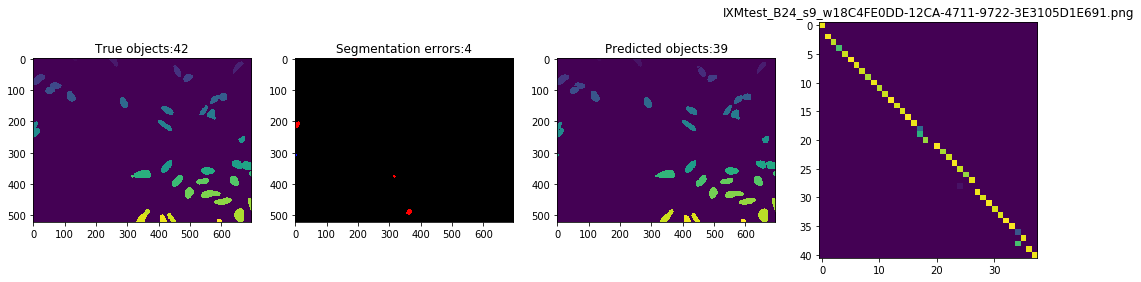

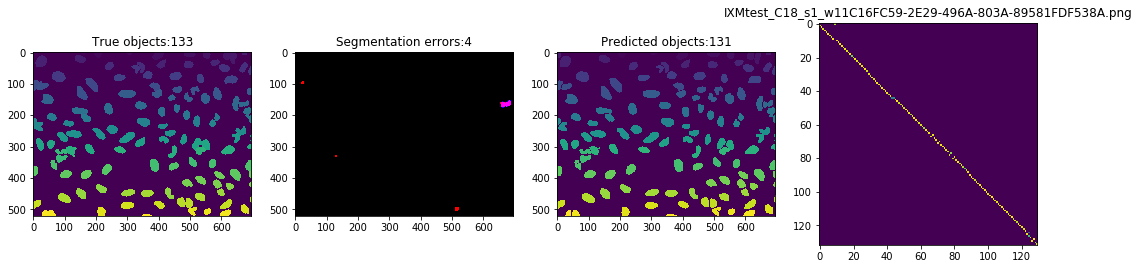

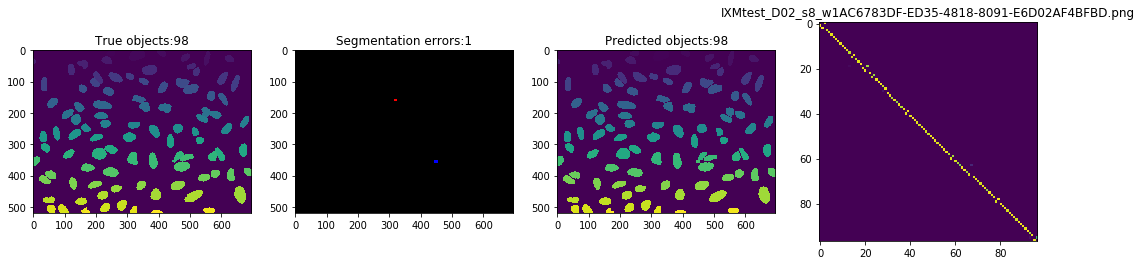

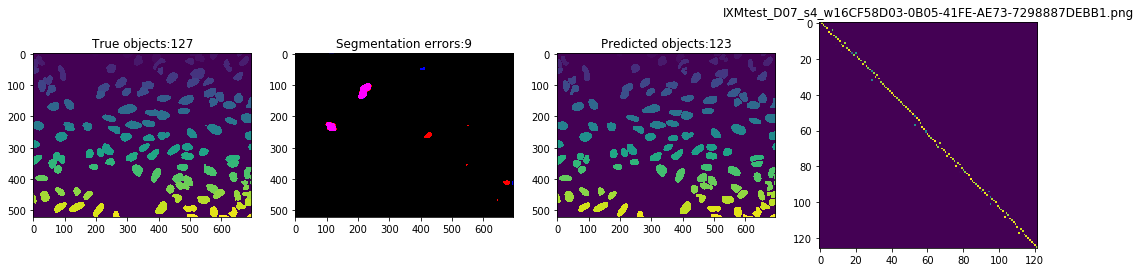

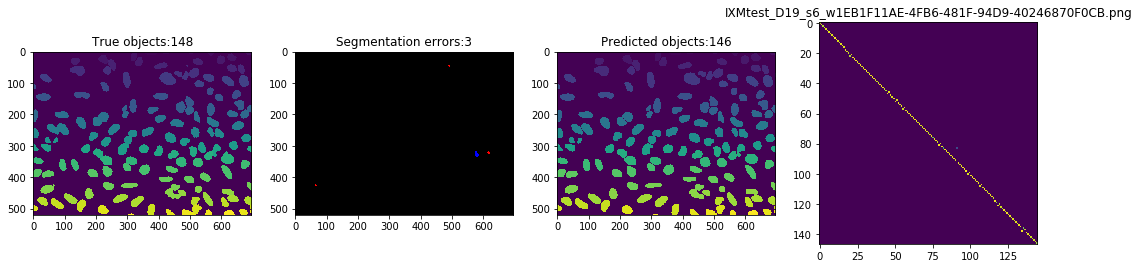

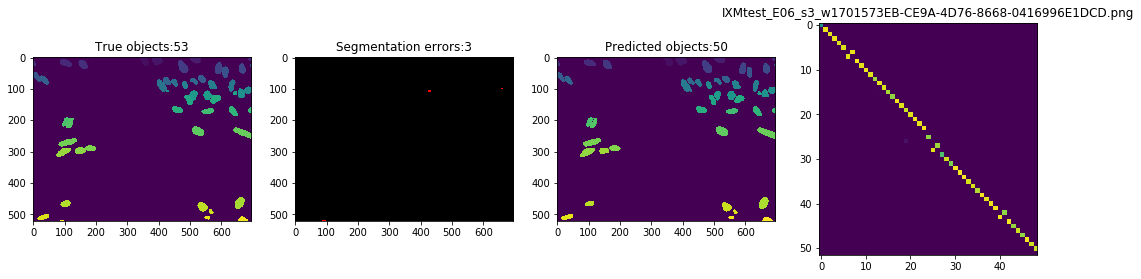

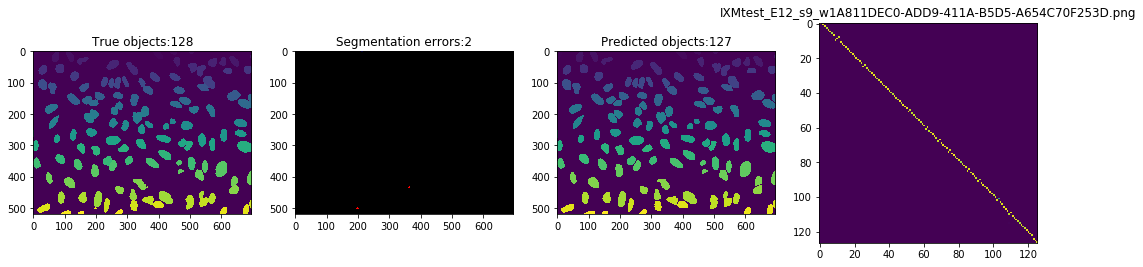

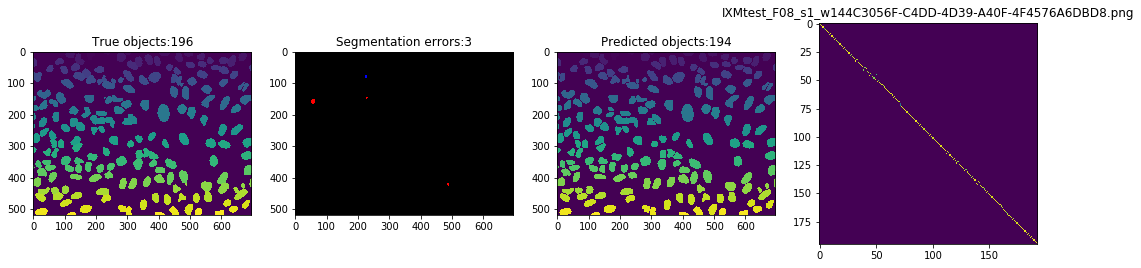

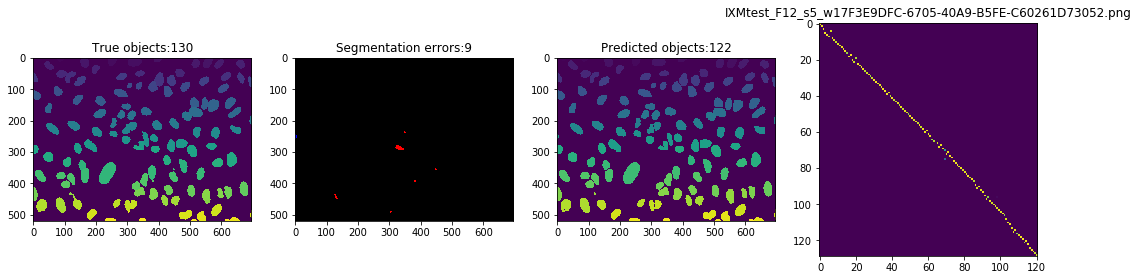

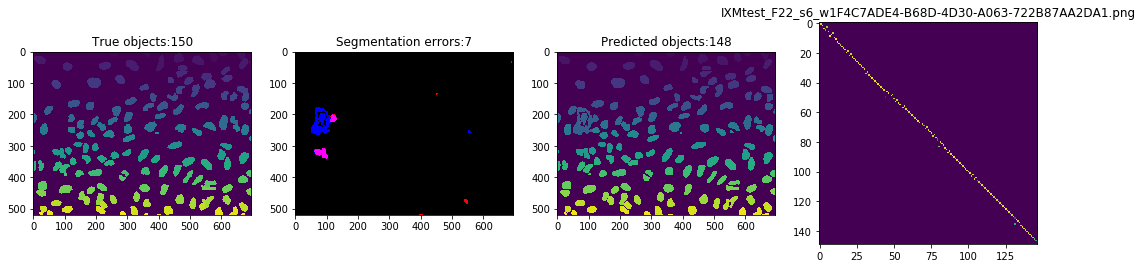

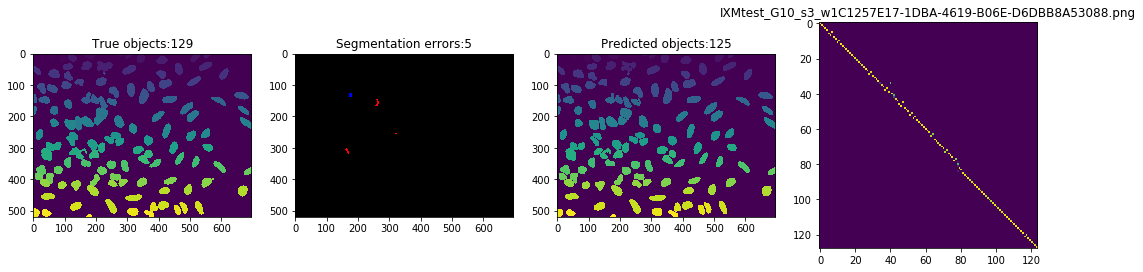

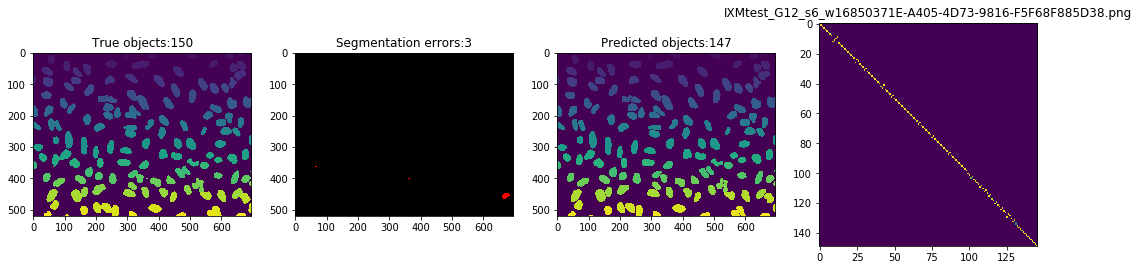

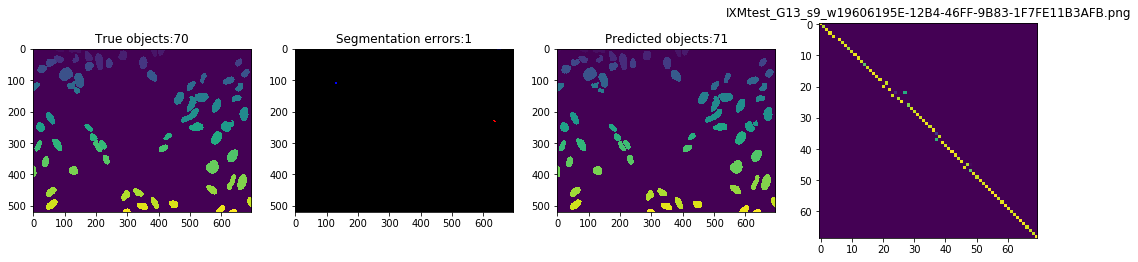

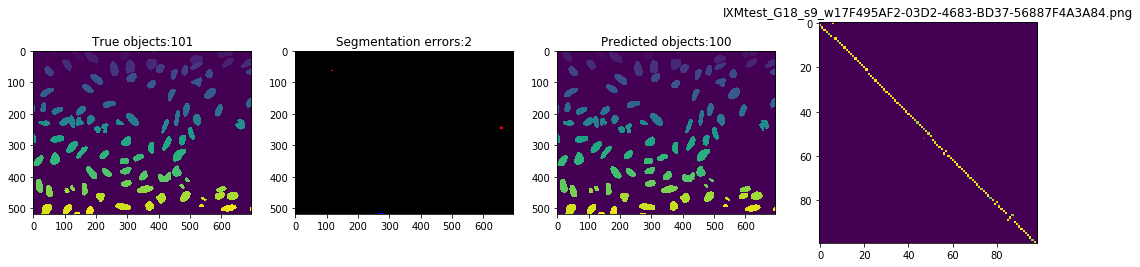

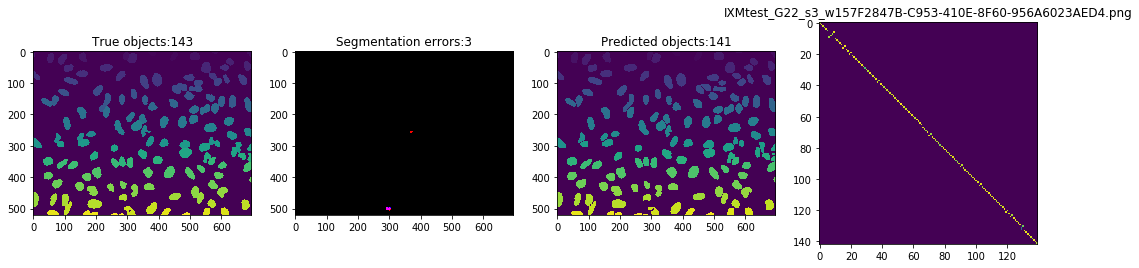

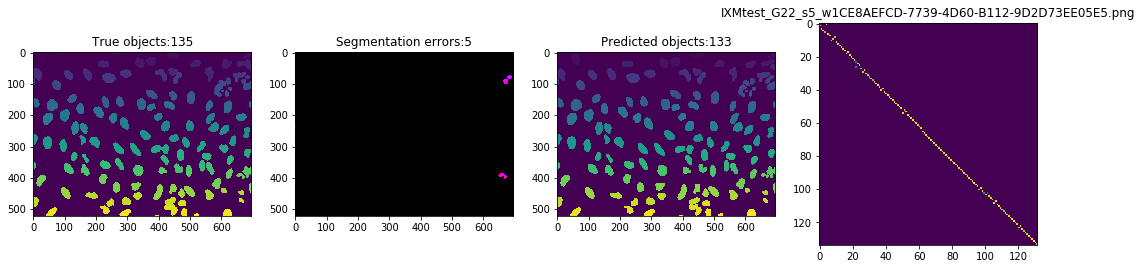

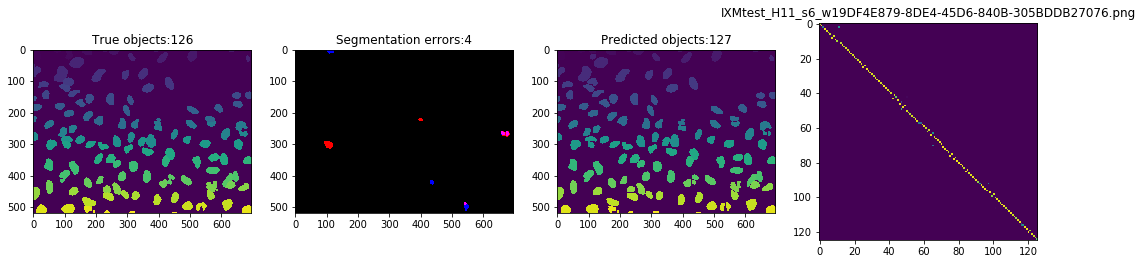

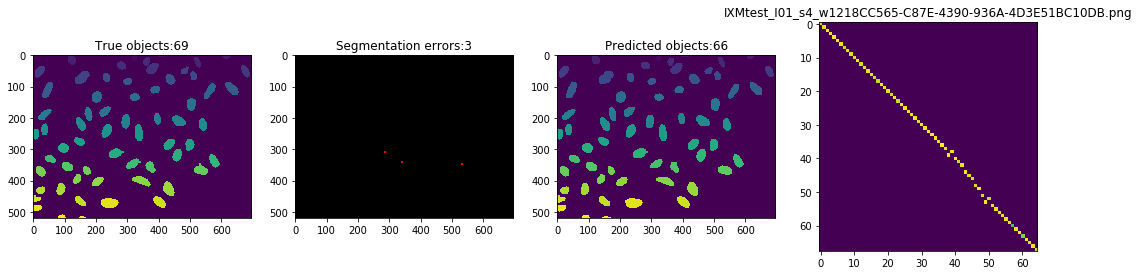

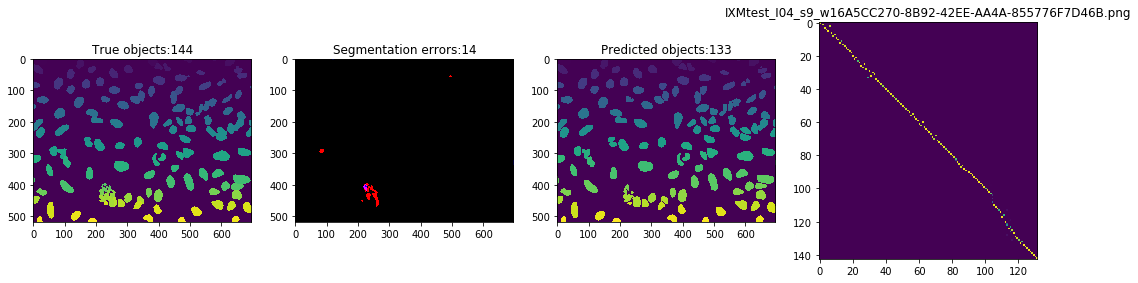

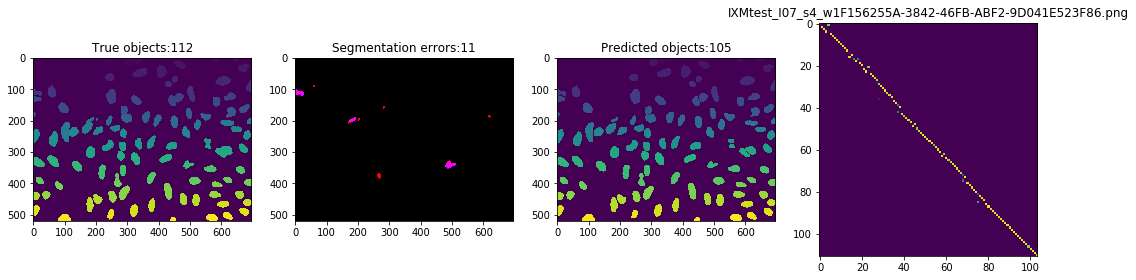

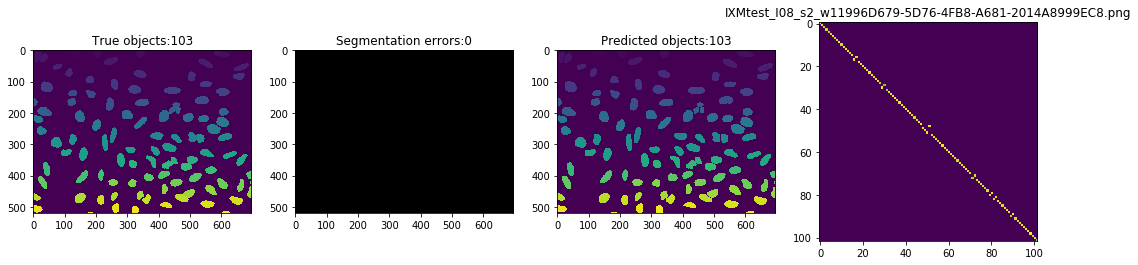

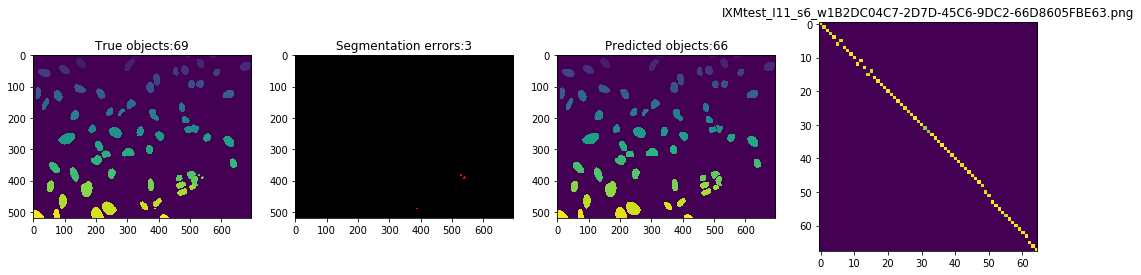

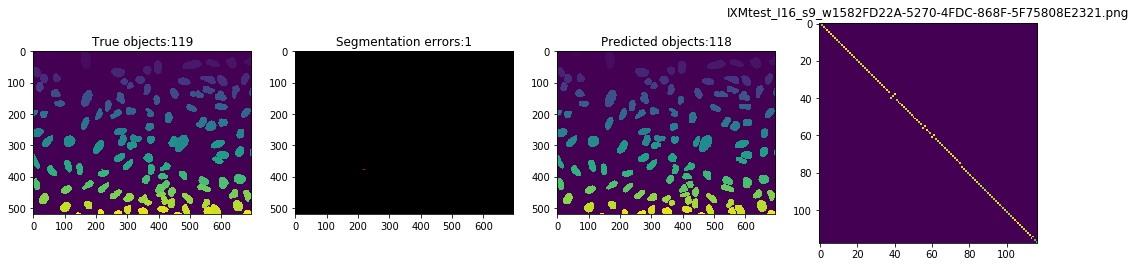

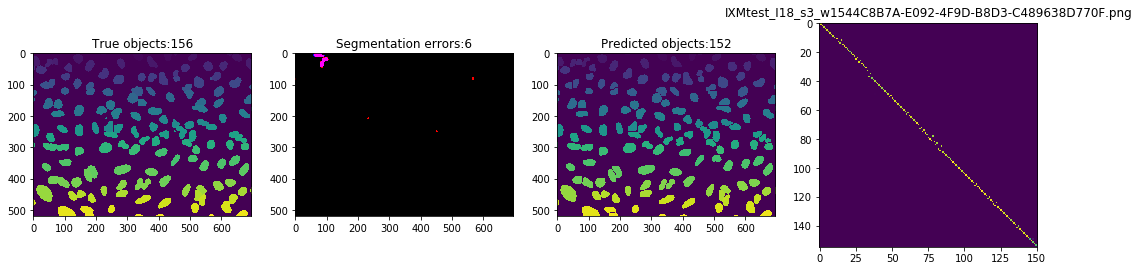

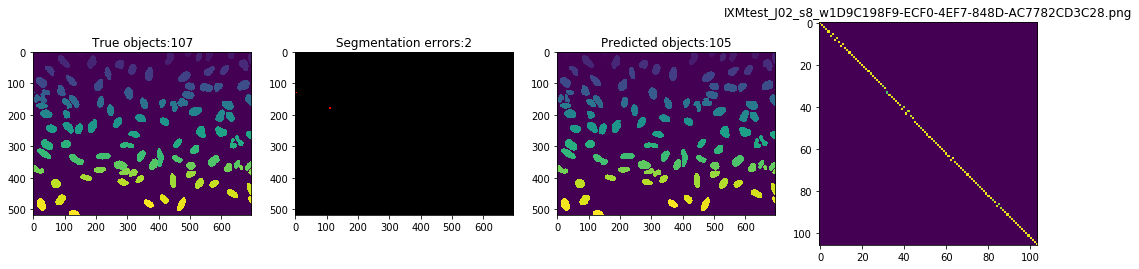

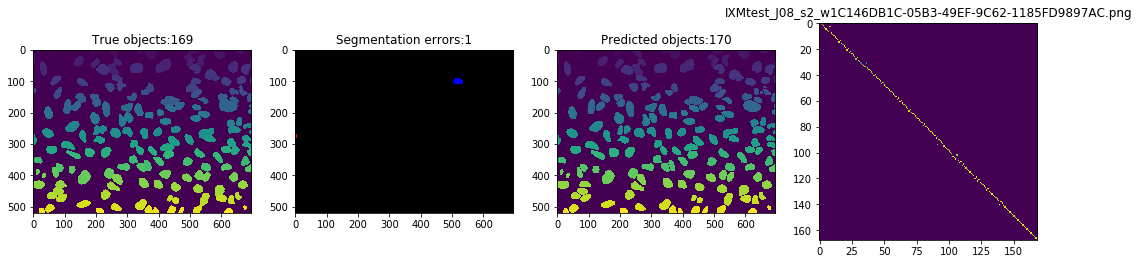

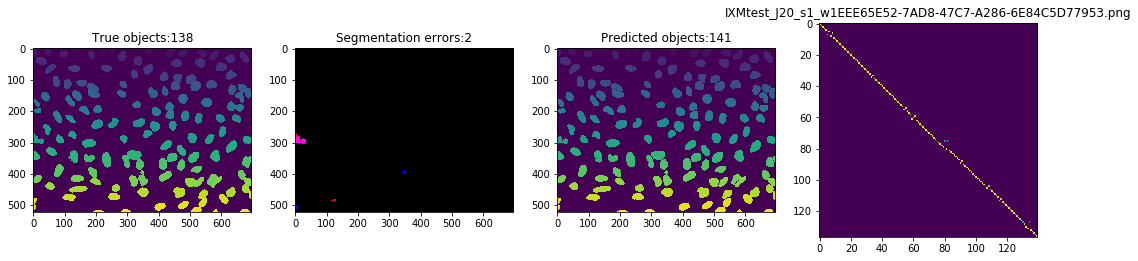

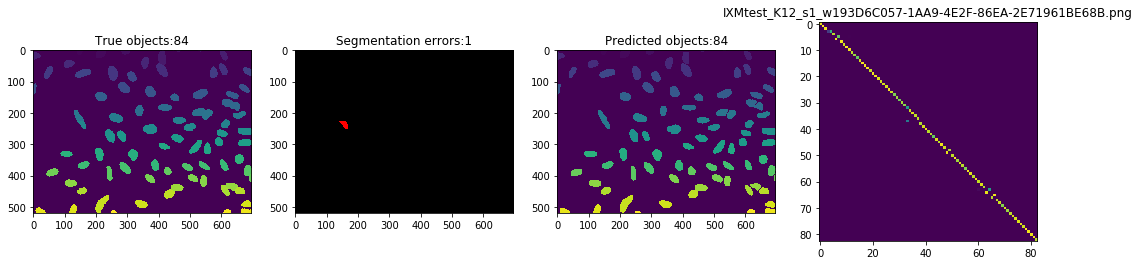

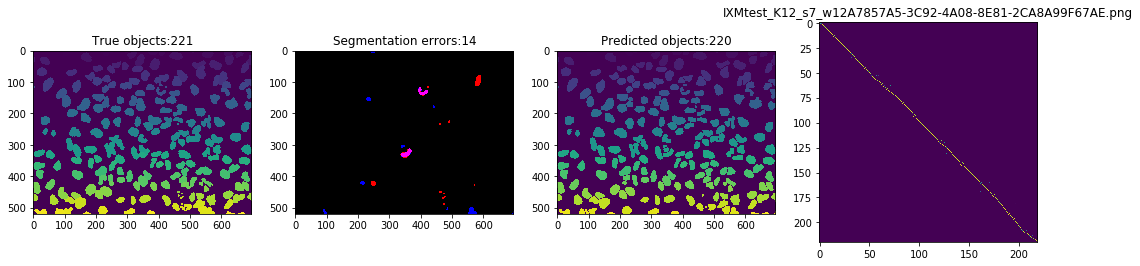

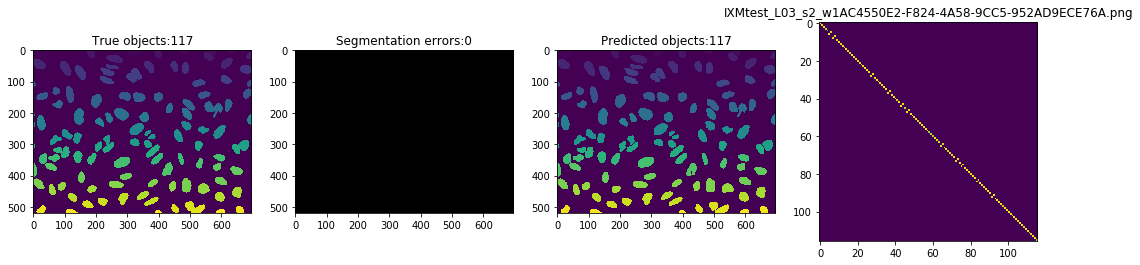

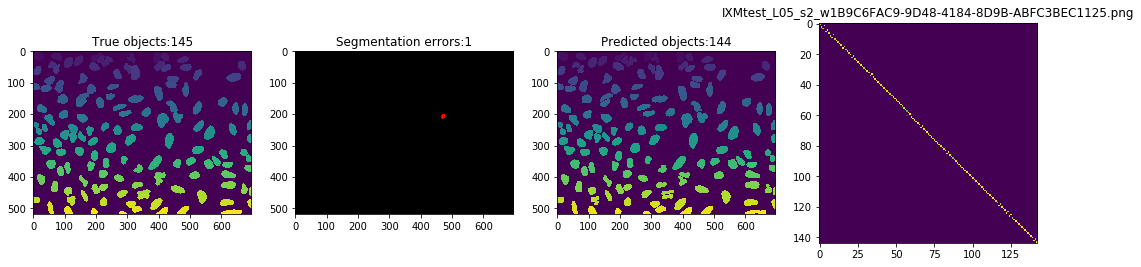

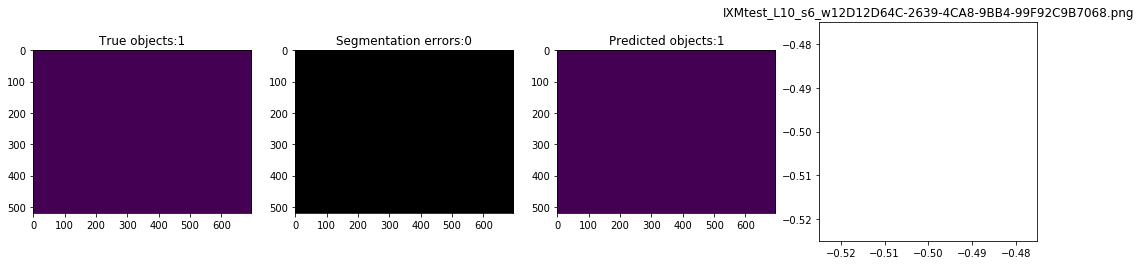

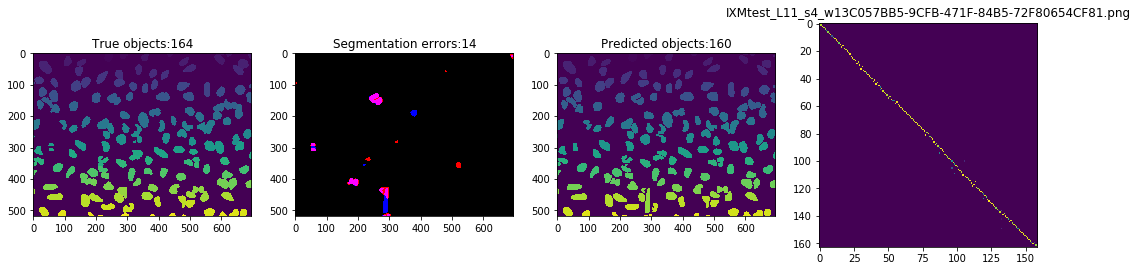

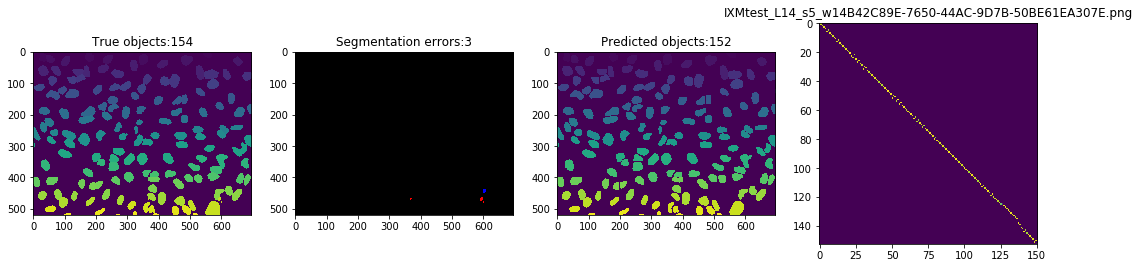

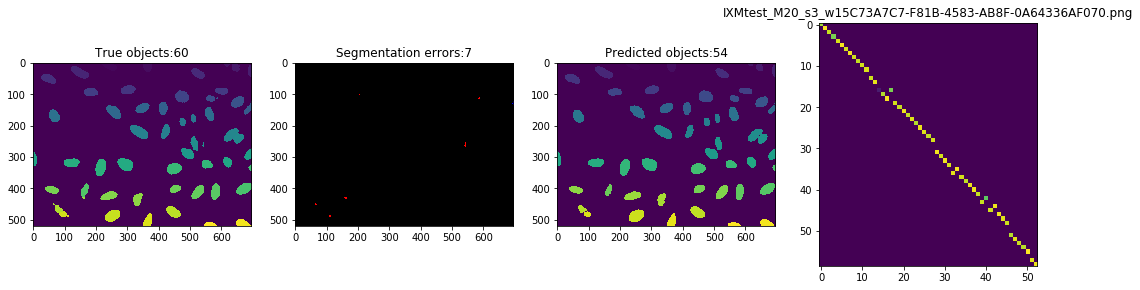

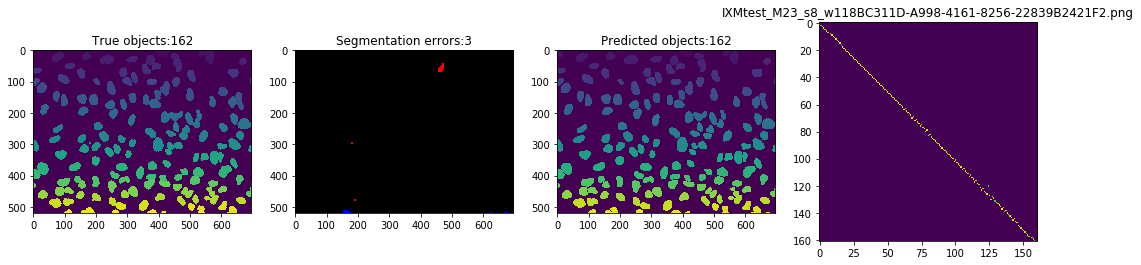

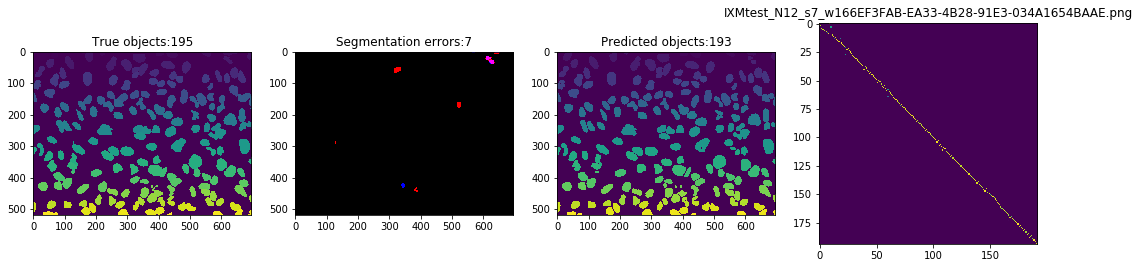

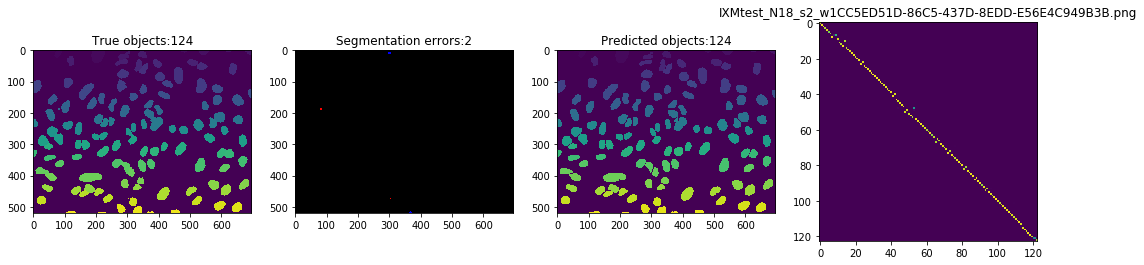

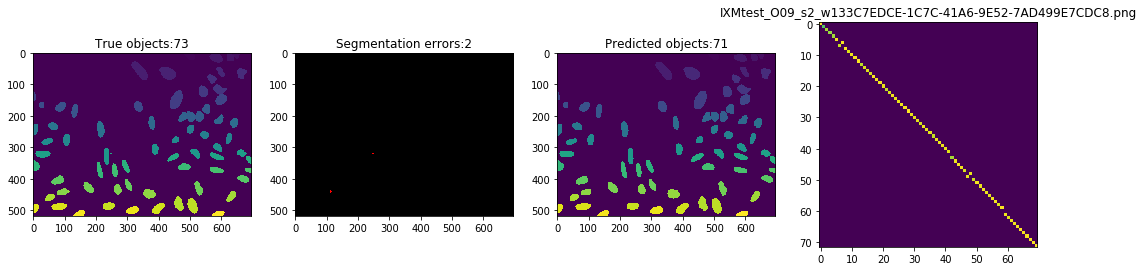

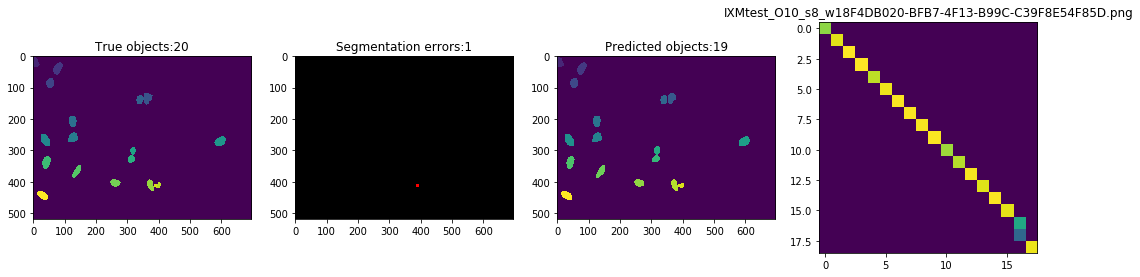

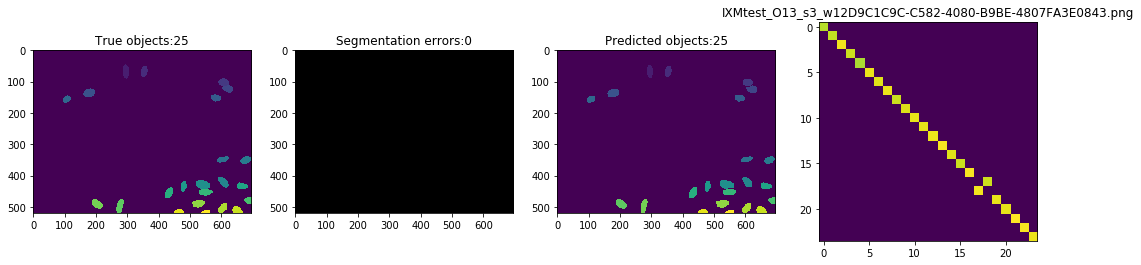

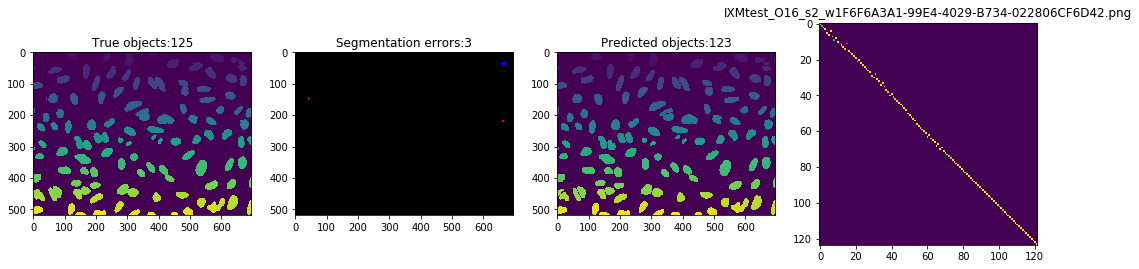

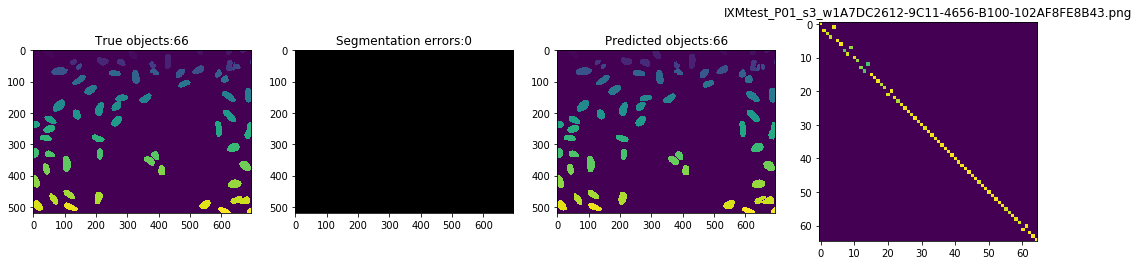

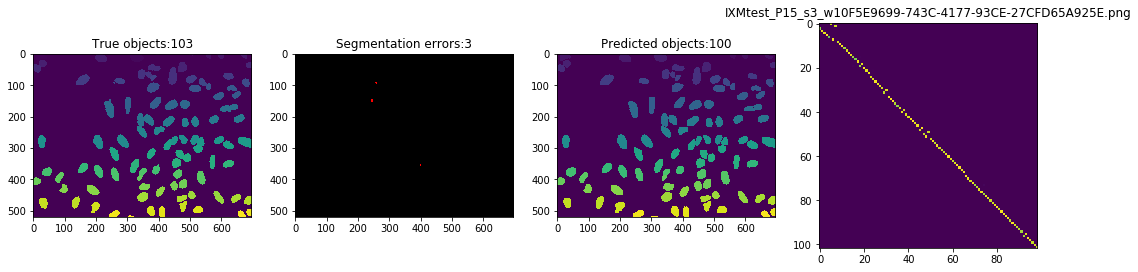

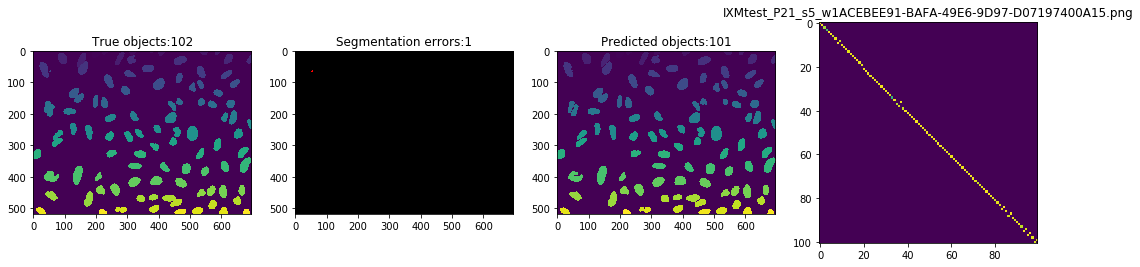

In [18]:
all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    if len(ground_truth.shape) == 3:
       # ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    ####################################################################################    
    #### Testing prediction with no small objects on annot and prediction #####
    ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=25) 
    prediction = skimage.morphology.remove_small_objects(prediction, min_size=25)
    #####################################################################################
    
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    false_positives = utils.evaluation.get_false_positives(
        ground_truth, 
        prediction, 
        false_positives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    #if image_name == all_images[0]:
    show(ground_truth, prediction, image_name=image_name)

# Report of results

,Image,Threshold,F1,Jaccard
45,IXMtest_O13_s3_w12D9C1C9C-C582-4080-B9BE-4807F...,0.725,0.950000,0.945750
34,IXMtest_L03_s2_w1AC4550E2-F824-4A58-9CC5-952AD...,0.725,0.937931,0.944880
26,IXMtest_I11_s6_w1B2DC04C7-2D7D-45C6-9DC2-66D86...,0.725,0.930827,0.945815
29,IXMtest_J02_s8_w1D9C198F9-ECF0-4EF7-848D-AC778...,0.725,0.929524,0.939721
49,IXMtest_P21_s5_w1ACEBEE91-BAFA-49E6-9D97-D0719...,0.725,0.929353,0.941405
43,IXMtest_O09_s2_w133C7EDCE-1C7C-41A6-9E52-7AD49...,0.725,0.923944,0.942337
4,IXMtest_B19_s7_w1E43B84DB-39E2-4BFB-8CB4-554B3...,0.725,0.919318,0.938623
9,IXMtest_D19_s6_w1EB1F11AE-4FB6-481F-94D9-40246...,0.725,0.917808,0.932476
25,IXMtest_I08_s2_w11996D679-5D76-4FB8-A681-2014A...,0.725,0.916667,0.931152
7,IXMtest_D02_s8_w1AC6783DF-ED35-4818-8091-E6D02...,0.725,0.914433,0.924771


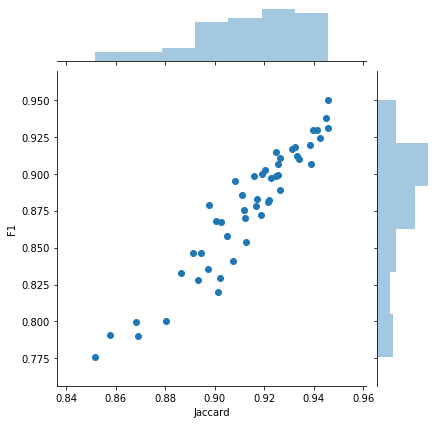

In [20]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)

,Threshold,F1,Jaccard
0,0.50,0.956453,0.895168
1,0.55,0.952901,0.895168
2,0.60,0.949708,0.895168
3,0.65,0.945912,0.895168
4,0.70,0.940903,0.895168
5,0.75,0.933858,0.895168
6,0.80,0.918195,0.895168
7,0.85,0.872830,0.895168
8,0.90,0.743827,0.895168
9,0.95,0.382088,0.895168


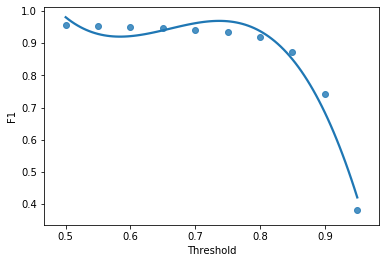

In [21]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [22]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.8596674209941098
Jaccard index: 0.8951676217840749


In [13]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      378.0
Small nuclei     138.0
Normal nuclei      2.0
Large nuclei       NaN
Name: False_Negative, dtype: float64

In [14]:
falseP = false_positives[false_positives["False_Positive"] == 1]

FP_Area_chart = falseP.groupby(
    pd.cut(
        falseP["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Positive"].sum()

total_Positives = len(false_positives)
print(FP_Area_chart)

print("FDR Tiny:", "%.4f" % (FP_Area_chart["Tiny nuclei"]/total_Positives))

print("FDR Small:", "%.4f" % (FP_Area_chart["Small nuclei"]/total_Positives))

print("FDR Normal:", "%.4f" % (FP_Area_chart["Normal nuclei"]/total_Positives))

print("FDR Large:", "%.4f" % (FP_Area_chart["Large nuclei"]/total_Positives))


Area
Tiny nuclei       60
Small nuclei     111
Normal nuclei      6
Large nuclei       1
Name: False_Positive, dtype: int64
FDR Tiny: 0.0108
FDR Small: 0.0200
FDR Normal: 0.0011
FDR Large: 0.0002


In [23]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 38
Merges: 48


In [24]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 178


In [25]:
thresh = 0.7


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 178
True positives: 5378
Total objects: 5556
False discovery rate: 0.032037437005039596
